In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import scipy.io
import scipy.optimize as op

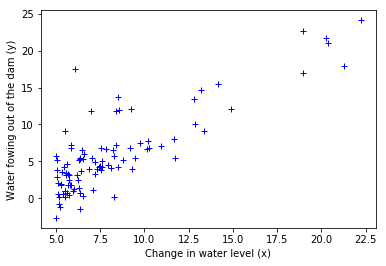

In [2]:
data = np.genfromtxt('./ex1/ex1data1.txt', delimiter=',')

m = len(data)
X = np.resize(data[:,0], (m, 1))
y = np.resize(data[:,1], (m, 1))

X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)
X_train_orig, X_val_orig, y_train, y_val = train_test_split(
    X_train_orig, y_train, test_size=0.2, random_state=10)

X_train = np.column_stack([np.ones(len(X_train_orig)), X_train_orig])
X_val = np.column_stack([np.ones(len(X_val_orig)), X_val_orig])
X_test = np.column_stack([np.ones(len(X_test_orig)), X_test_orig])

max_x = np.max(X)
min_x = np.min(X)

plt.plot(X, y, 'b+')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water fowing out of the dam (y)')
plt.show()

In [3]:
def compute_cost(theta, X, y, lambdaa):
    theta = theta.reshape((len(theta), 1))
    
    m = len(X)
    h = X.dot(theta)
    theta_reg = theta[1:]
    
    cost = 1 / 2 / m * (h - y).T.dot(h - y)
    reg  = lambdaa / 2 / m * theta_reg.T.dot(theta_reg)
    return np.sum(cost + reg)

# https://github.com/takehilo/coursera-machine-learning-python/blob/master/ex5/functions.py
def compute_grad(theta, X, y, lambdaa):
    theta = theta.reshape(len(theta), 1)
    
    m = len(X)
    h = X.dot(theta)

    error = h - y
    theta_reg = theta[1:]
    
    grad = np.zeros(theta.shape)
    grad[0] = 1 / m * X.T[0].dot(error)
    grad[1:] = 1 / m * X.T[1:].dot(error) + lambdaa / m * theta_reg

    return grad.ravel()

def train(X, y, lambdaa):
    return op.fmin_cg(f = compute_cost,
                      x0 = np.zeros(np.size(X, axis=1)),
                      args = (X, y, lambdaa),
                      fprime = compute_grad,
                      disp = False)

def train2(X, y, lambdaa, method='TNC'):
    result = op.minimize(fun = compute_cost,
                         x0 = np.zeros(np.size(X, axis=1)),
                         args = (X, y, lambdaa),
                         method = method,
                         jac = compute_grad)
    
    return result.x

def polyFeatures(X, p):
    col = X[:,0]
    columns = []
    for i in range(1, p + 1):
        columns.append(col ** i)

    return np.column_stack([*columns])

def normalizeFeatures(X):
    mean = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    return (X - mean) / sigma, mean, sigma
    
theta = np.array([1, 1])
cost = compute_cost(theta, X_train, y_train, 1);
print('Cost at theta = [1 ; 1]: {:.6f} (should be about 10.486426)'.format(cost));

grad = compute_grad(theta, X_train, y_train, 1);
print('Grad at theta = [1 ; 1]: {} (should be about [3.43397787 24.94826133])'.format(grad));

Cost at theta = [1 ; 1]: 9.824223 (should be about 10.486426)
Grad at theta = [1 ; 1]: [ 3.23598967 23.507333  ] (should be about [3.43397787 24.94826133])


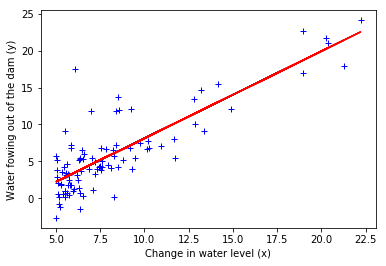

In [4]:
theta = train(X_train, y_train, 0)

plt.plot(X, y, 'b+')
plt.plot(X, np.column_stack([np.ones(m), X]).dot(theta), 'r-')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water fowing out of the dam (y)')
plt.show()

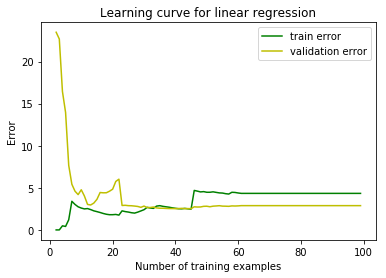

In [5]:
training_examples = np.arange(2, 100)

error_train = np.zeros(len(training_examples))
error_val = np.zeros(len(training_examples))
error_test = np.zeros(len(training_examples))

for i, m in enumerate(training_examples):
    Xtrain = X_train[:m,:]
    ytrain = y_train[:m,:]
    
    theta = train(Xtrain, ytrain, 0)
    error_train[i] = compute_cost(theta, Xtrain, ytrain, 0)
    error_val[i] = compute_cost(theta, X_val, y_val, 0)
    error_test[i] = compute_cost(theta, X_test, y_test, 0)
    
plt.plot(training_examples, error_train, 'g-', label="train error")
plt.plot(training_examples, error_val, 'y-', label="validation error")
# plt.plot(training_examples, error_test, 'r-', label="test error")
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression')
plt.legend()
plt.show()

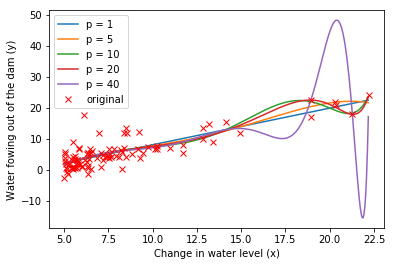

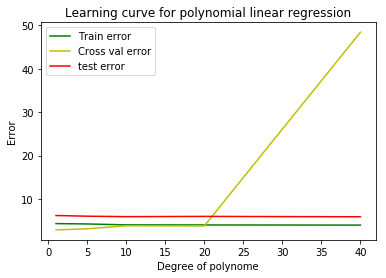

In [6]:
lambdaa = 0

polynomials = [1, 5, 10, 20, 40]

error_train = np.zeros(len(polynomials))
error_val = np.zeros(len(polynomials))
error_test = np.zeros(len(polynomials))

for i, p in enumerate(polynomials):
    X_train_poly, mean, sigma = normalizeFeatures(polyFeatures(X_train_orig, p))
    X_val_poly = (polyFeatures(X_val_orig, p) - mean) / sigma
    X_test_poly = (polyFeatures(X_test_orig, p) - mean) / sigma

    X_train_poly = np.column_stack([np.ones(len(X_train_poly)), X_train_poly])
    X_val_poly = np.column_stack([np.ones(len(X_val_poly)), X_val_poly])
    X_test_poly = np.column_stack([np.ones(len(X_test_poly)), X_test_poly])
    
    theta = train2(X_train_poly, y_train, lambdaa)
    
    x = np.arange(min_x, max_x, 0.05).reshape(-1, 1)
    x_poly = np.column_stack([np.ones(len(x)), (polyFeatures(x, p) - mean) / sigma])
    
    plt.plot(x, x_poly.dot(theta), '-', label='p = ' + str(p))
    
    error_train[i] = compute_cost(theta, X_train_poly, y_train, 0)
    error_val[i] = compute_cost(theta, X_val_poly, y_val, 0)
    error_test[i] = compute_cost(theta, X_test_poly, y_test, 0)
    
plt.plot(X, y, 'rx', label='original')
plt.legend()
plt.xlabel('Change in water level (x)')
plt.ylabel('Water fowing out of the dam (y)')
plt.show()

plt.plot(polynomials, error_train, 'g-', label='Train error')
plt.plot(polynomials, error_val,'y-', label='Cross val error')
plt.plot(polynomials, error_test,'r-', label='test error')
plt.legend()
plt.xlabel('Degree of polynome')
plt.ylabel('Error')
plt.title('Learning curve for polynomial linear regression')
plt.show()

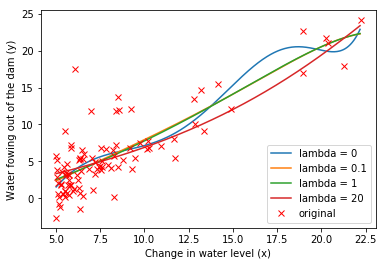

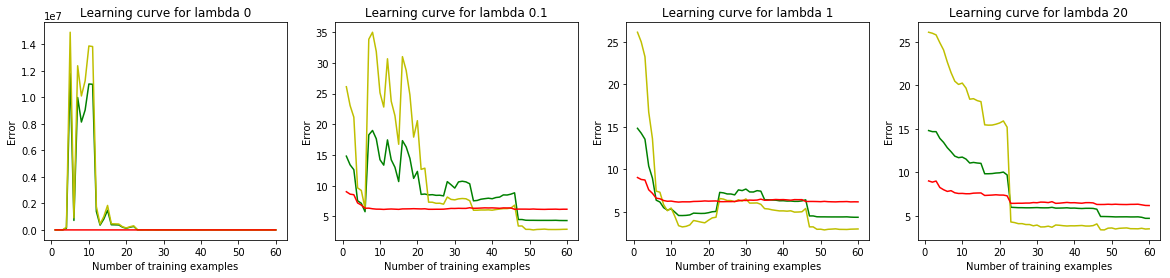

In [7]:
p = 8

X_train_poly, mean, sigma = normalizeFeatures(polyFeatures(X_train_orig, p))
X_val_poly = (polyFeatures(X_val_orig, p) - mean) / sigma
X_test_poly = (polyFeatures(X_test_orig, p) - mean) / sigma

X_train_poly = np.column_stack([np.ones(len(X_train_poly)), X_train_poly])
X_val_poly = np.column_stack([np.ones(len(X_val_poly)), X_val_poly])
X_test_poly = np.column_stack([np.ones(len(X_test_poly)), X_test_poly])

# lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
lambdas = [0, 0.1, 1, 20]

max_x = np.max(X)
min_x = np.min(X)

for i, lambdaa in enumerate(lambdas):
    theta = train2(X_train_poly, y_train, lambdaa)

    x = np.arange(min_x, max_x, 0.05).reshape(-1, 1)
    x_poly = (polyFeatures(x, p) - mean) / sigma
    x_poly = np.column_stack([np.ones(len(x_poly)), x_poly])
    
    plt.plot(x, x_poly.dot(theta), '-', label='lambda = ' + str(lambdaa))

plt.plot(X, y, 'rx', label='original')
plt.legend()
plt.xlabel('Change in water level (x)')
plt.ylabel('Water fowing out of the dam (y)')
plt.show()

for i, lambdaa in enumerate(lambdas):
    training_examples = np.arange(1, len(X_train))
    error_train = np.zeros(len(training_examples))
    error_val = np.zeros(len(training_examples))
    error_test = np.zeros(len(training_examples))
    
    for j in training_examples:
        Xtrain = X_train_poly[:j,:]
        ytrain = y_train[:j,:]

        theta = train(Xtrain, ytrain, lambdaa)
        error_train[j - 1] = compute_cost(theta, X_train_poly, y_train, 0)
        error_val[j - 1] = compute_cost(theta, X_val_poly, y_val, 0)
        error_test[j - 1] = compute_cost(theta, X_test_poly, y_test, 0)

    plt.subplot(1, len(lambdas), i + 1)
    plt.plot(training_examples, error_train, 'g-')
    plt.plot(training_examples, error_val, 'y-')
    plt.plot(training_examples, error_test, 'r-')
    
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Learning curve for lambda %s' % lambdaa)
    
fig = plt.gcf()
fig.set_figwidth(20)
# fig.set_size_inches(20, 5)
plt.show()